In [1]:
%matplotlib inline
import os, sqlite3
import pandas as pd
import matplotlib.pyplot as plt
# DB = os.environ.get('DB', '../db.sqlite')
DB = os.environ.get('DB', '../db_preprocessed.sqlite')
db = sqlite3.connect(DB)
db.row_factory = lambda x,y: dict(sqlite3.Row(x,y))
cur = db.cursor()

# How many column-spanning rows do we remove?

In [10]:
ccls1 = pd.read_sql('SELECT cellClass, COUNT(*) AS n FROM cells GROUP BY cellClass', db)
ccls1

cellClass         n
0      None  63440920
1         H   1308629
2         L      2507
3         R    179699

In [11]:
ccls2 = pd.read_sql('SELECT cellClass, COUNT(*) AS n FROM tablecaptions GROUP BY cellClass', db)
ccls2

cellClass       n
0        None     164
1      footer   66364
2  fromheader   72986
3    original  172421

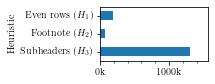

In [189]:
import matplotlib as mpl
ccls = pd.concat([ccls1,ccls2]).set_index('cellClass')
ccls = ccls.drop([None, 'L', 'fromheader', 'original'])
ccls.index.name = 'Heuristic'
ccls = ccls.rename(index={
    'R': 'Even rows ($H_1$)',
    'footer': 'Footnote ($H_2$)',
    'H': 'Subheaders ($H_3$)',
}).sort_index(ascending=False) 

ax = ccls['n'].plot.barh(
    xlim=[0,ccls['n'].max()*1.2],
    figsize = (1.5,.75),
)
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x,p:f'{x/1000:.0f}k'))
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))

mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.savefig('count-mergechunks-plot.pgf', bbox_inches = 'tight', pad_inches = 0)

In [123]:
ccls['n'].sum()

1554692

# What is the improvement of Union Tables?
(How good are we at using popular entities to disambiguate relations for unpopular ones?)

In [124]:
%%time
gold_user = 'sample-A-benno-clusters:benno-integration:headerunion--check:benno'

df = pd.read_sql("""
    SELECT clusterId, col, prop, propScore, propCount, qualProp, propGood 
    FROM annotation_clustercols 
    WHERE (user=:gold_user) AND (propGood IS NOT NULL)
""", db, params=dict(gold_user=gold_user))

def accuracy(df):
    print(len(df))
    return sum(df['propGood'] == 1) / len(df['propGood']) if len(df) else 0

df

CPU times: user 9.1 ms, sys: 2.09 ms, total: 11.2 ms
Wall time: 9.95 ms


clusterId  col       prop  propScore  propCount     qualProp  propGood
0         4852    1         65   0.000235          1  493649954.0         1
1         4852    2  493649954   0.046417        526  493649954.0        -1
2         5063    0         27   0.024927         17          NaN         1
3         5063    2  493630234   0.029326         20          NaN        -1
4         5063    3  493630234   0.007331          5          NaN         1
..         ...  ...        ...        ...        ...          ...       ...
171    1418477    5  493630918   0.000245          3          NaN         1
172    1418477    6  493630918   0.000163          2          NaN         1
173    1529640    0  493632627   0.010728         19          NaN         1
174    1529640    1  493667039   0.068027         60          NaN         1
175    1529640    2  493632627   0.011744         20  493632627.0         1

[176 rows x 7 columns]

In [158]:
%%time
db2 = sqlite3.connect("../output/sample-A/20jan-oraclepivots/clusters/noclusters/db.sqlite")

df = pd.read_sql("""
    SELECT clusterId, col, prop, propScore, propCount, qualProp, propGood 
    FROM annotation_clustercols 
    WHERE (prop IS NOT NULL)
""", db2, params=dict(gold_user=gold_user))

def accuracy(df):
    print(len(df))
    return sum(df['propGood'] == 1) / len(df['propGood']) if len(df) else 0

MINCOUNT = 2
MINSCORE = .1
score = {}

f = df2 = df
print(f'Un-Filtered Precision: %.2f' % accuracy(f) )
f = df[(df['propCount'] > MINCOUNT)]
print(f'Count-Filtered Precision: %2f' % accuracy(f) )
f = df[(df['propScore'] >= MINSCORE)]
print(f'Score-Filtered Precision: %2f' % accuracy(f) )

f = df[(df['propCount'] > MINCOUNT) & (df['propScore'] >= MINSCORE) & df["qualProp"].isna()]
score['Binary'] = accuracy(f)
f = df[(df['propCount'] > MINCOUNT) & (df['propScore'] >= MINSCORE) & ~df["qualProp"].isna()]
score['N-ary'] = accuracy(f)

f = df[(df['propCount'] > MINCOUNT) & (df['propScore'] >= MINSCORE)]
score['All'] = accuracy(f)

score

104
26
130
CPU times: user 23.5 ms, sys: 1.02 ms, total: 24.5 ms
Wall time: 23 ms


{'Binary': 0.0, 'N-ary': 0.0, 'All': 0.0}

In [159]:
df2

clusterId  col       prop  propScore  propCount     qualProp propGood
0           15    0  493655839   0.500000          1          NaN     None
1           15    1        115   0.500000          1  493655839.0     None
2           15    4  493628961   0.500000          1  493655839.0     None
3           18    0  493633272   0.083333          3          NaN     None
4           24    3  493629842   0.666667          4          NaN     None
..         ...  ...        ...        ...        ...          ...      ...
315        756   -1         94   1.000000          8          NaN     None
316        770   -1  493628903   0.500000          1          NaN     None
317        772   -1         94   1.000000          8          NaN     None
318        777   -1  493658131   1.000000          6  493655839.0     None
319        787   -1         94   0.333333         16          NaN     None

[320 rows x 7 columns]

In [161]:
gold_user = 'sample-A-benno-clusters:benno-integration:headerunion--check:benno'

df = pd.read_sql("""
    SELECT clusterId, col, prop, propScore, propCount, qualProp, propGood 
    FROM annotation_clustercols 
    WHERE (user=:gold_user) AND (propGood IS NOT NULL)
""", db, params=dict(gold_user=gold_user))
df

clusterId  col       prop  propScore  propCount     qualProp  propGood
0         4852    1         65   0.000235          1  493649954.0         1
1         4852    2  493649954   0.046417        526  493649954.0        -1
2         5063    0         27   0.024927         17          NaN         1
3         5063    2  493630234   0.029326         20          NaN        -1
4         5063    3  493630234   0.007331          5          NaN         1
..         ...  ...        ...        ...        ...          ...       ...
171    1418477    5  493630918   0.000245          3          NaN         1
172    1418477    6  493630918   0.000163          2          NaN         1
173    1529640    0  493632627   0.010728         19          NaN         1
174    1529640    1  493667039   0.068027         60          NaN         1
175    1529640    2  493632627   0.011744         20  493632627.0         1

[176 rows x 7 columns]